In [1]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class RBF(nn.Module):
    def __init__(self):
        super(RBF, self).__init__()
        torch.cuda.manual_seed(0)
        
        self.rbf_clt = self.init_clt()
        self.rbf_std = self.init_std()
        

    def init_clt(self):
        return nn.Parameter(torch.rand(1))

    def init_std(self):
        return nn.Parameter(torch.rand(1))
    
    def rbf(self, x, cluster, std):
        return torch.exp(-(x - cluster) * (x - cluster) / 2 * (std * std))
    
    
    def forward(self, x):     
        
        x = self.rbf(x, self.rbf_clt, self.rbf_std)
    
        return x

In [3]:
class RBFnetwork(nn.Module):
    def __init__(self, timelag):
        super(RBFnetwork, self).__init__()
        torch.cuda.manual_seed(0)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.timelag = timelag
        self.init_weight = nn.Parameter(torch.rand(self.timelag))
        self.rbf_list = [RBF().to(device) for i in range(self.timelag)]
        
    def forward(self, x):

        for j in range(self.timelag):
            if j ==0:
                y = sum([self.init_weight[i] * self.rbf_list[i](x[j]) for i in range(self.timelag)])    
            else:
                y = torch.cat([y, sum([self.init_weight[i] * self.rbf_list[i](x[j]) for i in range(self.timelag)])])
        
        return y

In [4]:
def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params
        
def train_RBFlayer(model, input_, target, lr, epochs, lookback = 5, device = device):
    model.to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    train_loss_list = []
    
    best_it = None
    best_model = None
    best_loss = np.inf
    
    target_list = []
    
    for j in range(len(target) - 2):
        target_list.append((target[j+2] - target[j])/2)
    
    loss_list = []
    cause_list = []
    for epoch in range(epochs):
        cause = model(input_)
        cause_list.append(cause)
        grad = []
        
        
        for i in range(len(cause) - 2):
            grad.append((cause[i+2] - cause[i])/2)
        
        loss1 = sum([loss_fn(grad[i], target_list[i]) for i in range(len(grad))])
        loss2 = sum([loss_fn(cause[i], target[i]) for i in range(len(input_))])
        
        loss = loss1 + loss2
        
        loss.backward()
        optimizer.step()
        model.zero_grad()
        
        loss_list.append(loss)
        mean_loss = loss / len(grad)
        train_loss_list.append(mean_loss)
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_it = epoch
            best_model = deepcopy(model)
            
        elif (epoch - best_it) == lookback:
            if verbose:
                print('Stopping early')
            break
        print("epoch {} cause loss {} :".format(epoch, loss / len(input_)))
        print('gradient loss :', loss1/len(grad))
        print('value loss :', loss2/len(input_))
                
    best_cause = cause_list[best_it]    
    restore_parameters(model, best_model)

    return best_model, loss_list, best_cause

# data generation

In [13]:
import random as rand
import numpy as np

def data_gen(timelag):
    data = []
    clt_list = []
    std_list = []
    for i in range(timelag):
        clt = rand.random()
        std = rand.random()
        
        data_i = np.exp(-(i - clt) * (i - clt) / 2 * (std * std))
        data.append(data_i)
        clt_list.append(clt)
        std_list.append(std)
    return torch.tensor(data, device = device).float(), torch.tensor(clt_list, device = device).float(), torch.tensor(std_list, device = device).float()

In [14]:
data, clt_list, std_list = data_gen(10)

In [15]:
data

tensor([9.9985e-01, 9.9821e-01, 7.1884e-01, 4.1960e-01, 8.1678e-01, 3.2533e-01,
        3.3063e-06, 7.6426e-01, 7.1675e-01, 1.0674e-08], device='cuda:0')

In [16]:
clt_list

tensor([0.0251, 0.5282, 0.6747, 0.9138, 0.5042, 0.4979, 0.5171, 0.0435, 0.8379,
        0.4082], device='cuda:0')

In [17]:
std_list

tensor([0.6994, 0.1270, 0.6131, 0.6317, 0.1820, 0.3329, 0.9163, 0.1054, 0.1139,
        0.7052], device='cuda:0')

# test1

In [28]:
import time

cause_list = []

start = time.time()
model = RBFnetwork(10)
best_model, loss_list, best_cause = train_RBFlayer(model, data, data, 0.001, 1000, device)
cause_list.append(best_cause.cpu().detach().numpy())
print("time :", time.time() - start)
print('-------------------------------------------------------------------------------------------')


epoch 0 cause loss 17.742481231689453 :
gradient loss : tensor(0.0978, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(17.6643, device='cuda:0', grad_fn=<DivBackward0>)
epoch 1 cause loss 17.660694122314453 :
gradient loss : tensor(0.0977, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(17.5825, device='cuda:0', grad_fn=<DivBackward0>)
epoch 2 cause loss 17.579105377197266 :
gradient loss : tensor(0.0977, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(17.5010, device='cuda:0', grad_fn=<DivBackward0>)
epoch 3 cause loss 17.49771499633789 :
gradient loss : tensor(0.0977, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(17.4196, device='cuda:0', grad_fn=<DivBackward0>)
epoch 4 cause loss 17.41652488708496 :
gradient loss : tensor(0.0976, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(17.3384, device='cuda:0', grad_fn=<DivBackward0>)
epoch 5 cause loss 17.335540771484375 :
gradient loss : tensor(0.0976, device='cuda:0', grad

gradient loss : tensor(0.0962, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(14.2149, device='cuda:0', grad_fn=<DivBackward0>)
epoch 46 cause loss 14.221099853515625 :
gradient loss : tensor(0.0962, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(14.1441, device='cuda:0', grad_fn=<DivBackward0>)
epoch 47 cause loss 14.150545120239258 :
gradient loss : tensor(0.0962, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(14.0736, device='cuda:0', grad_fn=<DivBackward0>)
epoch 48 cause loss 14.080256462097168 :
gradient loss : tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(14.0033, device='cuda:0', grad_fn=<DivBackward0>)
epoch 49 cause loss 14.010231018066406 :
gradient loss : tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(13.9333, device='cuda:0', grad_fn=<DivBackward0>)
epoch 50 cause loss 13.940467834472656 :
gradient loss : tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>)
value loss : 

epoch 93 cause loss 11.183735847473145 :
gradient loss : tensor(0.0947, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(11.1080, device='cuda:0', grad_fn=<DivBackward0>)
epoch 94 cause loss 11.125102996826172 :
gradient loss : tensor(0.0947, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(11.0493, device='cuda:0', grad_fn=<DivBackward0>)
epoch 95 cause loss 11.066710472106934 :
gradient loss : tensor(0.0947, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(10.9910, device='cuda:0', grad_fn=<DivBackward0>)
epoch 96 cause loss 11.00855541229248 :
gradient loss : tensor(0.0946, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(10.9328, device='cuda:0', grad_fn=<DivBackward0>)
epoch 97 cause loss 10.950640678405762 :
gradient loss : tensor(0.0946, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(10.8750, device='cuda:0', grad_fn=<DivBackward0>)
epoch 98 cause loss 10.892964363098145 :
gradient loss : tensor(0.0946, device='cuda:0

value loss : tensor(8.6997, device='cuda:0', grad_fn=<DivBackward0>)
epoch 139 cause loss 8.725987434387207 :
gradient loss : tensor(0.0934, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(8.6513, device='cuda:0', grad_fn=<DivBackward0>)
epoch 140 cause loss 8.677775382995605 :
gradient loss : tensor(0.0934, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(8.6031, device='cuda:0', grad_fn=<DivBackward0>)
epoch 141 cause loss 8.629776954650879 :
gradient loss : tensor(0.0934, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(8.5551, device='cuda:0', grad_fn=<DivBackward0>)
epoch 142 cause loss 8.581988334655762 :
gradient loss : tensor(0.0933, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(8.5073, device='cuda:0', grad_fn=<DivBackward0>)
epoch 143 cause loss 8.53441333770752 :
gradient loss : tensor(0.0933, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(8.4598, device='cuda:0', grad_fn=<DivBackward0>)
epoch 144 cause loss 8

epoch 184 cause loss 6.7582221031188965 :
gradient loss : tensor(0.0922, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(6.6844, device='cuda:0', grad_fn=<DivBackward0>)
epoch 185 cause loss 6.7189764976501465 :
gradient loss : tensor(0.0922, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(6.6452, device='cuda:0', grad_fn=<DivBackward0>)
epoch 186 cause loss 6.679917335510254 :
gradient loss : tensor(0.0922, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(6.6062, device='cuda:0', grad_fn=<DivBackward0>)
epoch 187 cause loss 6.6410441398620605 :
gradient loss : tensor(0.0922, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(6.5673, device='cuda:0', grad_fn=<DivBackward0>)
epoch 188 cause loss 6.602353572845459 :
gradient loss : tensor(0.0921, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(6.5286, device='cuda:0', grad_fn=<DivBackward0>)
epoch 189 cause loss 6.563847541809082 :
gradient loss : tensor(0.0921, device='cuda:0'

gradient loss : tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(5.0322, device='cuda:0', grad_fn=<DivBackward0>)
epoch 232 cause loss 5.073905944824219 :
gradient loss : tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(5.0010, device='cuda:0', grad_fn=<DivBackward0>)
epoch 233 cause loss 5.042923927307129 :
gradient loss : tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(4.9701, device='cuda:0', grad_fn=<DivBackward0>)
epoch 234 cause loss 5.0121002197265625 :
gradient loss : tensor(0.0911, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(4.9393, device='cuda:0', grad_fn=<DivBackward0>)
epoch 235 cause loss 4.9814348220825195 :
gradient loss : tensor(0.0910, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(4.9086, device='cuda:0', grad_fn=<DivBackward0>)
epoch 236 cause loss 4.950925350189209 :
gradient loss : tensor(0.0910, device='cuda:0', grad_fn=<DivBackward0>)
value loss : ten

gradient loss : tensor(0.0901, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(3.7321, device='cuda:0', grad_fn=<DivBackward0>)
epoch 279 cause loss 3.779930591583252 :
gradient loss : tensor(0.0901, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(3.7079, device='cuda:0', grad_fn=<DivBackward0>)
epoch 280 cause loss 3.7557969093322754 :
gradient loss : tensor(0.0901, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(3.6837, device='cuda:0', grad_fn=<DivBackward0>)
epoch 281 cause loss 3.7317955493927 :
gradient loss : tensor(0.0901, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(3.6597, device='cuda:0', grad_fn=<DivBackward0>)
epoch 282 cause loss 3.7079262733459473 :
gradient loss : tensor(0.0900, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(3.6359, device='cuda:0', grad_fn=<DivBackward0>)
epoch 283 cause loss 3.6841888427734375 :
gradient loss : tensor(0.0900, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tens

epoch 325 cause loss 2.799496650695801 :
gradient loss : tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(2.7281, device='cuda:0', grad_fn=<DivBackward0>)
epoch 326 cause loss 2.7809481620788574 :
gradient loss : tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(2.7096, device='cuda:0', grad_fn=<DivBackward0>)
epoch 327 cause loss 2.7625088691711426 :
gradient loss : tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(2.6912, device='cuda:0', grad_fn=<DivBackward0>)
epoch 328 cause loss 2.7441790103912354 :
gradient loss : tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(2.6728, device='cuda:0', grad_fn=<DivBackward0>)
epoch 329 cause loss 2.7259583473205566 :
gradient loss : tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(2.6546, device='cuda:0', grad_fn=<DivBackward0>)
epoch 330 cause loss 2.707845687866211 :
gradient loss : tensor(0.0891, device='cuda:0

gradient loss : tensor(0.0885, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.9820, device='cuda:0', grad_fn=<DivBackward0>)
epoch 372 cause loss 2.038830041885376 :
gradient loss : tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.9681, device='cuda:0', grad_fn=<DivBackward0>)
epoch 373 cause loss 2.024941921234131 :
gradient loss : tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.9542, device='cuda:0', grad_fn=<DivBackward0>)
epoch 374 cause loss 2.0111420154571533 :
gradient loss : tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.9404, device='cuda:0', grad_fn=<DivBackward0>)
epoch 375 cause loss 1.9974300861358643 :
gradient loss : tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.9267, device='cuda:0', grad_fn=<DivBackward0>)
epoch 376 cause loss 1.9838056564331055 :
gradient loss : tensor(0.0884, device='cuda:0', grad_fn=<DivBackward0>)
value loss : te

gradient loss : tensor(0.0878, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.4150, device='cuda:0', grad_fn=<DivBackward0>)
epoch 419 cause loss 1.4749668836593628 :
gradient loss : tensor(0.0878, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.4048, device='cuda:0', grad_fn=<DivBackward0>)
epoch 420 cause loss 1.4647921323776245 :
gradient loss : tensor(0.0877, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.3946, device='cuda:0', grad_fn=<DivBackward0>)
epoch 421 cause loss 1.4546869993209839 :
gradient loss : tensor(0.0877, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.3845, device='cuda:0', grad_fn=<DivBackward0>)
epoch 422 cause loss 1.4446511268615723 :
gradient loss : tensor(0.0877, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(1.3745, device='cuda:0', grad_fn=<DivBackward0>)
epoch 423 cause loss 1.434684157371521 :
gradient loss : tensor(0.0877, device='cuda:0', grad_fn=<DivBackward0>)
value loss : t

value loss : tensor(1.0038, device='cuda:0', grad_fn=<DivBackward0>)
epoch 466 cause loss 1.0661845207214355 :
gradient loss : tensor(0.0872, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.9965, device='cuda:0', grad_fn=<DivBackward0>)
epoch 467 cause loss 1.0588988065719604 :
gradient loss : tensor(0.0871, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.9892, device='cuda:0', grad_fn=<DivBackward0>)
epoch 468 cause loss 1.0516666173934937 :
gradient loss : tensor(0.0871, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.9820, device='cuda:0', grad_fn=<DivBackward0>)
epoch 469 cause loss 1.0444875955581665 :
gradient loss : tensor(0.0871, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.9748, device='cuda:0', grad_fn=<DivBackward0>)
epoch 470 cause loss 1.0373612642288208 :
gradient loss : tensor(0.0871, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.9677, device='cuda:0', grad_fn=<DivBackward0>)
epoch 471 cause 

epoch 513 cause loss 0.7766384482383728 :
gradient loss : tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.7073, device='cuda:0', grad_fn=<DivBackward0>)
epoch 514 cause loss 0.7715439796447754 :
gradient loss : tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.7022, device='cuda:0', grad_fn=<DivBackward0>)
epoch 515 cause loss 0.7664894461631775 :
gradient loss : tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.6972, device='cuda:0', grad_fn=<DivBackward0>)
epoch 516 cause loss 0.761474609375 :
gradient loss : tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.6922, device='cuda:0', grad_fn=<DivBackward0>)
epoch 517 cause loss 0.7564994692802429 :
gradient loss : tensor(0.0866, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.6872, device='cuda:0', grad_fn=<DivBackward0>)
epoch 518 cause loss 0.751563310623169 :
gradient loss : tensor(0.0866, device='cuda:0', 

gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.5145, device='cuda:0', grad_fn=<DivBackward0>)
epoch 559 cause loss 0.579935610294342 :
gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.5110, device='cuda:0', grad_fn=<DivBackward0>)
epoch 560 cause loss 0.57643061876297 :
gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.5075, device='cuda:0', grad_fn=<DivBackward0>)
epoch 561 cause loss 0.5729545950889587 :
gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.5040, device='cuda:0', grad_fn=<DivBackward0>)
epoch 562 cause loss 0.5695078372955322 :
gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.5006, device='cuda:0', grad_fn=<DivBackward0>)
epoch 563 cause loss 0.5660898089408875 :
gradient loss : tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)
value loss : ten

epoch 603 cause loss 0.4508454501628876 :
gradient loss : tensor(0.0859, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.3822, device='cuda:0', grad_fn=<DivBackward0>)
epoch 604 cause loss 0.44844895601272583 :
gradient loss : tensor(0.0858, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.3798, device='cuda:0', grad_fn=<DivBackward0>)
epoch 605 cause loss 0.44607359170913696 :
gradient loss : tensor(0.0858, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.3774, device='cuda:0', grad_fn=<DivBackward0>)
epoch 606 cause loss 0.4437192976474762 :
gradient loss : tensor(0.0858, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.3751, device='cuda:0', grad_fn=<DivBackward0>)
epoch 607 cause loss 0.44138598442077637 :
gradient loss : tensor(0.0858, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.3727, device='cuda:0', grad_fn=<DivBackward0>)
epoch 608 cause loss 0.439073383808136 :
gradient loss : tensor(0.0858, device='cu

epoch 650 cause loss 0.35871854424476624 :
gradient loss : tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2903, device='cuda:0', grad_fn=<DivBackward0>)
epoch 651 cause loss 0.3571610450744629 :
gradient loss : tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2887, device='cuda:0', grad_fn=<DivBackward0>)
epoch 652 cause loss 0.35561808943748474 :
gradient loss : tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2872, device='cuda:0', grad_fn=<DivBackward0>)
epoch 653 cause loss 0.35408979654312134 :
gradient loss : tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2857, device='cuda:0', grad_fn=<DivBackward0>)
epoch 654 cause loss 0.3525758683681488 :
gradient loss : tensor(0.0855, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2842, device='cuda:0', grad_fn=<DivBackward0>)
epoch 655 cause loss 0.3510760962963104 :
gradient loss : tensor(0.0855, device='c

gradient loss : tensor(0.0853, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2323, device='cuda:0', grad_fn=<DivBackward0>)
epoch 697 cause loss 0.29954248666763306 :
gradient loss : tensor(0.0853, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2313, device='cuda:0', grad_fn=<DivBackward0>)
epoch 698 cause loss 0.2985561788082123 :
gradient loss : tensor(0.0853, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2303, device='cuda:0', grad_fn=<DivBackward0>)
epoch 699 cause loss 0.29757970571517944 :
gradient loss : tensor(0.0853, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2294, device='cuda:0', grad_fn=<DivBackward0>)
epoch 700 cause loss 0.29661282896995544 :
gradient loss : tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.2284, device='cuda:0', grad_fn=<DivBackward0>)
epoch 701 cause loss 0.2956556975841522 :
gradient loss : tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>)
value loss

epoch 741 cause loss 0.2643706500530243 :
gradient loss : tensor(0.0851, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1963, device='cuda:0', grad_fn=<DivBackward0>)
epoch 742 cause loss 0.263742595911026 :
gradient loss : tensor(0.0851, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1957, device='cuda:0', grad_fn=<DivBackward0>)
epoch 743 cause loss 0.2631211578845978 :
gradient loss : tensor(0.0850, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1951, device='cuda:0', grad_fn=<DivBackward0>)
epoch 744 cause loss 0.2625060975551605 :
gradient loss : tensor(0.0850, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1945, device='cuda:0', grad_fn=<DivBackward0>)
epoch 745 cause loss 0.26189756393432617 :
gradient loss : tensor(0.0850, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1939, device='cuda:0', grad_fn=<DivBackward0>)
epoch 746 cause loss 0.26129549741744995 :
gradient loss : tensor(0.0850, device='cud

gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1735, device='cuda:0', grad_fn=<DivBackward0>)
epoch 788 cause loss 0.2410438060760498 :
gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1731, device='cuda:0', grad_fn=<DivBackward0>)
epoch 789 cause loss 0.24066558480262756 :
gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1728, device='cuda:0', grad_fn=<DivBackward0>)
epoch 790 cause loss 0.24029162526130676 :
gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1724, device='cuda:0', grad_fn=<DivBackward0>)
epoch 791 cause loss 0.23992176353931427 :
gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1720, device='cuda:0', grad_fn=<DivBackward0>)
epoch 792 cause loss 0.23955591022968292 :
gradient loss : tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
value los

epoch 833 cause loss 0.22760961949825287 :
gradient loss : tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1598, device='cuda:0', grad_fn=<DivBackward0>)
epoch 834 cause loss 0.22738245129585266 :
gradient loss : tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1596, device='cuda:0', grad_fn=<DivBackward0>)
epoch 835 cause loss 0.22715787589550018 :
gradient loss : tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1594, device='cuda:0', grad_fn=<DivBackward0>)
epoch 836 cause loss 0.22693593800067902 :
gradient loss : tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1592, device='cuda:0', grad_fn=<DivBackward0>)
epoch 837 cause loss 0.2267165184020996 :
gradient loss : tensor(0.0847, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1590, device='cuda:0', grad_fn=<DivBackward0>)
epoch 838 cause loss 0.22649966180324554 :
gradient loss : tensor(0.0847, device=

epoch 880 cause loss 0.2193545401096344 :
gradient loss : tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1517, device='cuda:0', grad_fn=<DivBackward0>)
epoch 881 cause loss 0.21922428905963898 :
gradient loss : tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1516, device='cuda:0', grad_fn=<DivBackward0>)
epoch 882 cause loss 0.21909554302692413 :
gradient loss : tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>)
epoch 883 cause loss 0.21896834671497345 :
gradient loss : tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1513, device='cuda:0', grad_fn=<DivBackward0>)
epoch 884 cause loss 0.21884272992610931 :
gradient loss : tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1512, device='cuda:0', grad_fn=<DivBackward0>)
epoch 885 cause loss 0.21871860325336456 :
gradient loss : tensor(0.0846, device=

gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1472, device='cuda:0', grad_fn=<DivBackward0>)
epoch 926 cause loss 0.21474047005176544 :
gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1472, device='cuda:0', grad_fn=<DivBackward0>)
epoch 927 cause loss 0.21466639637947083 :
gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1471, device='cuda:0', grad_fn=<DivBackward0>)
epoch 928 cause loss 0.21459321677684784 :
gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1470, device='cuda:0', grad_fn=<DivBackward0>)
epoch 929 cause loss 0.21452103555202484 :
gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1469, device='cuda:0', grad_fn=<DivBackward0>)
epoch 930 cause loss 0.21444964408874512 :
gradient loss : tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>)
value lo

epoch 971 cause loss 0.21217894554138184 :
gradient loss : tensor(0.0844, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1447, device='cuda:0', grad_fn=<DivBackward0>)
epoch 972 cause loss 0.21213693916797638 :
gradient loss : tensor(0.0844, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1446, device='cuda:0', grad_fn=<DivBackward0>)
epoch 973 cause loss 0.2120954990386963 :
gradient loss : tensor(0.0844, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1446, device='cuda:0', grad_fn=<DivBackward0>)
epoch 974 cause loss 0.21205459535121918 :
gradient loss : tensor(0.0844, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1445, device='cuda:0', grad_fn=<DivBackward0>)
epoch 975 cause loss 0.2120141237974167 :
gradient loss : tensor(0.0844, device='cuda:0', grad_fn=<DivBackward0>)
value loss : tensor(0.1445, device='cuda:0', grad_fn=<DivBackward0>)
epoch 976 cause loss 0.21197421848773956 :
gradient loss : tensor(0.0844, device='

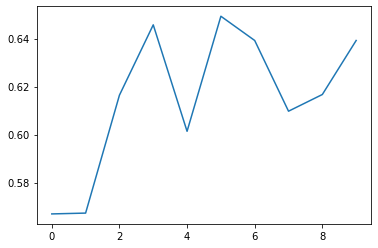

In [29]:
import matplotlib.pyplot as plt
plt.plot(cause_list[0])

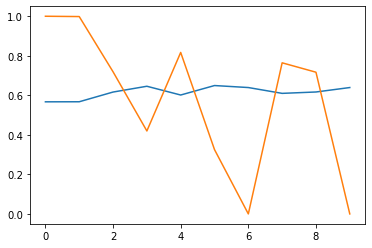

In [30]:
plt.plot(cause_list[0])
plt.plot(data.cpu().detach().numpy())
plt.show()